<a href="https://colab.research.google.com/github/bala-codes/SENTIMENT-ANALYSIS-ON-TWITTER-POSTS-USING-ML-AND-DL/blob/master/codes%20(DL)/Sentiment%20Analysis%20-%20TWITTER%20-%201-D%20CNN%20with%20Word%20Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Importing the libraries which are required.
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [ ]:
import pandas as pd

final_df = pd.read_csv('/content/drive/My Drive/Machine Learning Projects/SENTIMENT ANALYSIS - TWITTER POSTS REVIEWS/SOURCE CODES AND DATASETS/TWITTER ANALYSIS - FINAL DATASETS/final_df_tweets_cleaned.csv',index_col = False)  # SAVE THE FINAL CLEANED COPY IF YOU WANT 

final_df = pd.DataFrame(final_df)
final_df.head()

,label,text_cleaned
0,0,awww bummer shoulda get david carr third day
1,0,upset cannot update facebook texting might cry...
2,0,dive many time ball manage save rest bound
3,0,whole body feel itchy like fire
4,0,behave mad cannot see


In [ ]:
final_df.dropna(inplace=True)

final_df.shape

(1572905, 2)

In [ ]:
final_df['text_cleaned'] = final_df['text_cleaned'].astype(str)

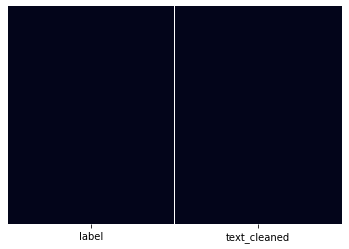

In [ ]:
import seaborn as sns
sns.heatmap(final_df.isnull(),yticklabels=False,cbar=False)

In [ ]:
from sklearn.model_selection import train_test_split

sentences = final_df['text_cleaned'].values
y = final_df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.30, random_state=123)
print(sentences_train.shape, sentences_test.shape)
print(y_train.shape, y_test.shape)

(1101033,) (471872,)
(1101033,) (471872,)


# A Convolutional Neural Network

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=20000, lower=True)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

Using TensorFlow backend.


In [ ]:
import pickle

with open('/content/drive/My Drive/Machine Learning Projects/SENTIMENT ANALYSIS - TWITTER POSTS REVIEWS/SOURCE CODES AND DATASETS/PACKAGE 2 - SOURCE CODES AND FILES/Pretrained Models/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X_train[0]

[74, 132, 320, 398, 706, 131, 129, 542]

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 300 # 300 -> 400 for glove 300d 

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
print(X_train[100])

[ 369 2503 1292    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    print("X",x)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# **TENSORFLOW MODEL BUILD FROM SCRATCH**

In [ ]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

# **Build sequence model**

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.callbacks import *
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D, SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
import tensorflow as tf

def sepcnn_model_arch2(blocks,filters,kernel_size,embedding_dim,dropout_rate,pool_size,input_shape,num_classes,num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):

    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape,
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(Conv1D(filters=filters,                                 
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  #depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(Conv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  #depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(rate=dropout_rate)) #
        
        #######################################################################

        model.add(Conv1D(filters=filters * 2,                                   
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  padding='same'))
        
        model.add(Conv1D(filters=filters * 2,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(rate=dropout_rate)) 

        ########################################################################

        model.add(Conv1D(filters=filters * 3,                                   
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  padding='same'))
        model.add(Conv1D(filters=filters * 3,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(rate=dropout_rate)) 

        ########################################################################


    model.add(Conv1D(filters= filters*4,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              padding='same'))
    
    model.add(Conv1D(filters=filters*4,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              padding='same'))  
    
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(256, activation="relu")) # 256 -> 512
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam() # lr=1e-3
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    tf.keras.utils.plot_model(model,to_file='/content/model2.png',show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=False,dpi=96)
    return model

#sepcnn_model(blocks,filters,kernel_size,embedding_dim,
#             dropout_rate,pool_size,input_shape,num_classes,
#                 num_features,use_pretrained_embedding=False,
#                 is_embedding_trainable=False,embedding_matrix=None)

# Model trained for different kernel_size and their corresponding Accuracy rates

Kernel_size = 1 
1. Training Accuracy: 0. for kernel size of 1
2. Testing Accuracy:  0. for kernel size of 1

Kernel_size = 2
1. Training Accuracy: 0. for kernel size of 2
2. Testing Accuracy:  0. for kernel size of 2

Kernel_size = 3
1. Training Accuracy: 0. for kernel size of 3
2. Testing Accuracy:  0. for kernel size of 3

Kernel_size = 4
1. Training Accuracy: 0. for kernel size of 4
2. Testing Accuracy:  0. for kernel size of 4

Kernel_size = 5
1. Training Accuracy: 0. for kernel size of 5
2. Testing Accuracy:  0. for kernel size of 5


In [ ]:
# change kernel_size = 4 , 3 , 5
mymodelarch2 = sepcnn_model_arch2(blocks = 2, filters = 32 , kernel_size = 5 ,embedding_dim = 100 , dropout_rate = 0.5 , pool_size = 2, input_shape = maxlen ,num_classes = 2, num_features = vocab_size,use_pretrained_embedding=False,is_embedding_trainable=True,embedding_matrix=None)
mymodelarch2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          6621600   
_________________________________________________________________
dropout_35 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 300, 32)           16032     
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 300, 32)           5152      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 150, 32)           0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 150, 32)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 150, 64)          

In [ ]:
%%time
mc = ModelCheckpoint('/content/SA_Conv_k5.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# es = EarlyStopping(monitor='val_loss', patience=4)
# red_lr= ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=2,factor=0.001,min_delta=0.01)

history = mymodelarch2.fit(X_train, y_train,epochs=30,verbose=2,validation_data=(X_test, y_test),callbacks=[mc])

Train on 278770 samples, validate on 119474 samples
Epoch 1/30

Epoch 00001: val_acc improved from -inf to 0.87870, saving model to /content/SA_Conv_k5.h5
278770/278770 - 88s - loss: 0.5350 - acc: 0.6762 - val_loss: 0.3271 - val_acc: 0.8787
Epoch 2/30

Epoch 00002: val_acc did not improve from 0.87870
278770/278770 - 85s - loss: 0.3080 - acc: 0.8818 - val_loss: 0.3590 - val_acc: 0.8584
Epoch 3/30

Epoch 00003: val_acc improved from 0.87870 to 0.88344, saving model to /content/SA_Conv_k5.h5
278770/278770 - 85s - loss: 0.2827 - acc: 0.8931 - val_loss: 0.3028 - val_acc: 0.8834
Epoch 4/30

Epoch 00004: val_acc improved from 0.88344 to 0.88733, saving model to /content/SA_Conv_k5.h5
278770/278770 - 85s - loss: 0.2705 - acc: 0.8994 - val_loss: 0.2924 - val_acc: 0.8873
Epoch 5/30

Epoch 00005: val_acc did not improve from 0.88733
278770/278770 - 85s - loss: 0.2632 - acc: 0.9033 - val_loss: 0.3083 - val_acc: 0.8849
Epoch 6/30

Epoch 00006: val_acc did not improve from 0.88733
278770/278770 - 8

Training Accuracy: 0.9411
Testing Accuracy:  0.8783


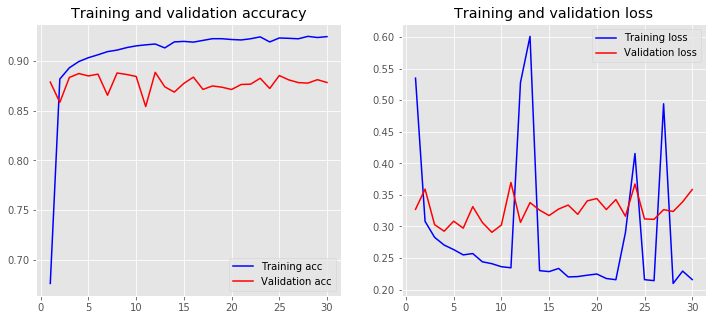

In [ ]:
###
loss, accuracy = mymodelarch2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mymodelarch2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

###
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# CONVNETS WITH EMBEDDED PRETRAINED MATRIX (GLOVE)

In [ ]:

!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip '/content/glove.twitter.27B.zip' -d '/content/'

--2019-12-03 07:12:11--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2019-12-03 07:12:11--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2019-12-03 07:12:11--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
# load the whole embedding into memory

embeddings_index = dict()
embedding_dims = []

#f = open('/content/drive/My Drive/Machine Learning Projects/SENTIMENT ANALYSIS - AMAZON CUSTOMER REVIEWS/SOURCE CODES AND DATASETS/PACKAGE 3 -SOURCE CODES AND FILES/Pretrained Models/Deep Learning Models - With Glove Embedding/glove.6B.100d.txt')

embedding_dims = input(print("Enter the Embedding Dimensions 100 or 300 :"))

f = open('/content/Glove_Embedding/glove.6B.{}d.txt'.format(embedding_dims))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

################################################################################

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, int(embedding_dims)))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

Enter the Embedding Dimensions 100 or 300 :
None300
Loaded 400000 word vectors.


In [ ]:
mymodel2 = sepcnn_model_arch2(blocks = 2, filters = 32 , kernel_size = 5 ,embedding_dim = int(embedding_dims) , dropout_rate = 0.5 , pool_size = 2, input_shape = maxlen ,num_classes = 2, num_features = vocab_size,use_pretrained_embedding=True,is_embedding_trainable=False,embedding_matrix=embedding_matrix)
mymodel2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 300, 300)          19864800  
_________________________________________________________________
dropout_70 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_80 (Conv1D)           (None, 300, 32)           48032     
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 300, 32)           5152      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 150, 32)           0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 150, 32)           0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 150, 64)         

In [ ]:
%%time
mc = ModelCheckpoint('/content/SA_conv_Glovex{}d.h5'.format(embedding_dims), monitor='val_acc', verbose=1, save_best_only=True, mode='max')
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=2,factor=0.001,min_delta=0.01)
#es = EarlyStopping(monitor='val_loss', patience=4)
history = mymodel2.fit(X_train, y_train,epochs=30,verbose=1,validation_data=(X_test, y_test),callbacks=[mc,red_lr])

loss, accuracy = mymodel2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mymodel2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 278770 samples, validate on 119474 samples
Epoch 1/30
278560/278770 [============================>.] - ETA: 0s - loss: 0.4417 - acc: 0.7963
Epoch 00001: val_acc improved from -inf to 0.86314, saving model to /content/SA_conv_Glovex300d.h5
278770/278770 [==============================] - 82s 293us/sample - loss: 0.4417 - acc: 0.7964 - val_loss: 0.3391 - val_acc: 0.8631
Epoch 2/30
278624/278770 [============================>.] - ETA: 0s - loss: 0.3662 - acc: 0.8479
Epoch 00002: val_acc improved from 0.86314 to 0.87234, saving model to /content/SA_conv_Glovex300d.h5
278770/278770 [==============================] - 75s 268us/sample - loss: 0.3662 - acc: 0.8480 - val_loss: 0.3499 - val_acc: 0.8723
Epoch 3/30
278752/278770 [============================>.] - ETA: 0s - loss: 0.3523 - acc: 0.8563
Epoch 00003: val_acc did not improve from 0.87234

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974512e-06.
278770/278770 [==============================] - 75s 271us/s

X range(1, 31)


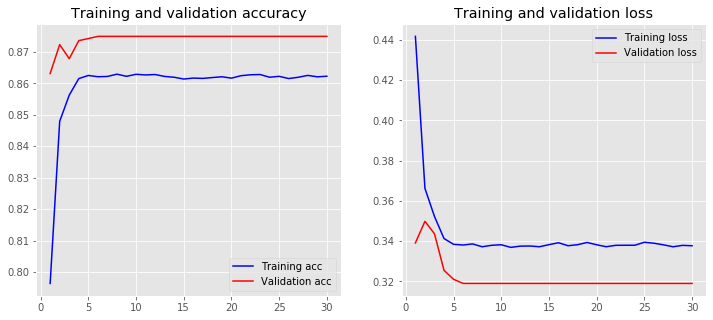

In [ ]:
# print('Validation accuracy: {acc}, loss: {loss}'.format(acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)
print("X",x)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Full edit do not touch 

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.callbacks import *
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D, SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
import tensorflow as tf

def sepcnn_model_arch(blocks,filters,kernel_size,embedding_dim,dropout_rate,pool_size,input_shape,num_classes,num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):

    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape,
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(Conv1D(filters=filters,                                 
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  #depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(Conv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  #depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(rate=dropout_rate)) #
        
        #######################################################################

        model.add(Conv1D(filters=filters * 2,                                   
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  padding='same'))
        
        model.add(Conv1D(filters=filters * 2,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(rate=dropout_rate)) 

        ########################################################################

        model.add(Conv1D(filters=filters * 3,                                   
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  padding='same'))
        model.add(Conv1D(filters=filters * 3,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(rate=dropout_rate)) 

        ########################################################################


    model.add(Conv1D(filters= filters*4,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              padding='same'))
    
    model.add(Conv1D(filters=filters*4,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              padding='same'))  
    
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(256, activation="relu")) # 256 -> 512
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam() # lr=1e-3
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    tf.keras.utils.plot_model(model,to_file='/content/model2.png',show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=False,dpi=96)
    return model

# Model trained for different kernel_size and their corresponding Accuracy rates

Kernel_size = 1 
1. Training Accuracy: 0.77 for kernel size of 1
2. Testing Accuracy:  0.76 for kernel size of 1

Kernel_size = 2
1. Training Accuracy: 0.79 for kernel size of 2
2. Testing Accuracy:  0.78 for kernel size of 2

Kernel_size = 3
1. Training Accuracy: 0.80 for kernel size of 3
2. Testing Accuracy:  0.78 for kernel size of 3

Kernel_size = 4
1. Training Accuracy: 0.81 for kernel size of 4
2. Testing Accuracy:  0.78 for kernel size of 4

Kernel_size = 5
1. Training Accuracy: 0.81 for kernel size of 5
2. Testing Accuracy:  0.78 for kernel size of 5


Kernel_size = 6
1. Training Accuracy: 0.50 for kernel size of 6
2. Testing Accuracy:  0.50 for kernel size of 6